In [11]:
import ast
from math import nan

import zipfile

import pandas as pd
import numpy as np

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('future.no_silent_downcasting', True)

def getData():

    # Attempt to read the data from './data.csv' and unzip it from './data.zip' if it doesn't exist
    try:
        open('./data.csv')
    except FileNotFoundError:
        with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
            zip_ref.extractall('./')

    data = pd.read_csv('./data.csv', sep=',', nrows=1000)
    data = data.drop(columns=['shoe_id', 'run_count', 'true_count', 'cards_remaining', 'dealer_up', 'initial_hand'])

    data['dealer_final'] = data['dealer_final'].apply(lambda x: ast.literal_eval(x))
    data['player_final'] = data['player_final'].apply(lambda x: ast.literal_eval(x))
    data['player_final_value'] = data['player_final_value'].apply(lambda x: ast.literal_eval(x))

    data['actions_taken'] = data['actions_taken'] \
        .apply(lambda x: ast.literal_eval(x)) \
        .apply(lambda x: [x[0] , ['P'] + x[1]]  if len(x)==2 else x) \
        .apply(lambda x: [x[0] , ['P'] + x[1], ['P'] + x[2]]  if len(x)==3 else x) \
        .apply(lambda x: [x[0] , ['P'] + x[1], ['P'] + x[2], ['P'] + x[3]]  if len(x)==4 else x) \
        .apply(lambda x: [x[0] , ['P'] + x[1], ['P'] + x[2], ['P'] + x[3] , ['P'] + x[4]]  if len(x)==5 else x)

    data = data.explode(['player_final','player_final_value','actions_taken'])

    data['dealer_final_value'] = data['dealer_final_value'].replace('BJ',21)
    data['player_final_value'] = data['player_final_value'].replace('BJ',21)

    data['dealer_final_value'] = data['dealer_final_value'].astype('int64')
    data['player_final_value'] = data['player_final_value'].astype('int64')

    data.loc[(data['dealer_final_value'] < data['player_final_value']) & (data['player_final_value'] <= 21) , 'win'] = 1
    data.loc[data['dealer_final_value'] >  21 , 'win'] = 1
    data.loc[data['dealer_final_value'] == data['player_final_value'], 'win'] = 0
    data.loc[(data['dealer_final_value'] > data['player_final_value']) & (data['dealer_final_value'] <= 21) , 'win'] = -1
    data.loc[data['player_final_value'] > 21 , 'win'] = -1
    data['win'] = data['win'].astype('int64')

    data = data[data['win'] == 1] # We only want to train our model on results where the player has won
    data = data.drop(columns=['win'])

    def cards_splitter(data,cards,text):
        stopsign = cards.apply(lambda x: len(x))
        for i in range(1,max(stopsign)):
            data[f'{text}{i}'] = cards.apply(lambda x: nan if len(x)<i else x[i-1])

    cards_splitter(data,data['player_final'],'player_card_')
    cards_splitter(data,data['dealer_final'],'dealer_card_')
    cards_splitter(data,data['actions_taken'],'action_taken_')
    data = data.drop(columns=['player_final', 'dealer_final', 'actions_taken'])


    def decompose_actions(row):
        frame = row.to_frame().transpose()
        num_action_cols = sum([1 for column in frame if column.startswith('action_taken_')])
        num_player_card_cols = sum([1 for column in frame if column.startswith('player_card_')])
        data = []

        for action_index in range(1, num_action_cols + 1):
            column = f"action_taken_{action_index}"
            new_row = row.copy()

            offset = 0

            new_row['action_taken'] = row[column]

            if row[column] == 'H':
                offset = 1

            if row[column] is nan:
                break

            for new_action_index in range(action_index + 1, num_action_cols + 1):
                new_column = f"action_taken_{new_action_index}"
                new_row[new_column] = nan

            for player_card_index in range(action_index + 2 + offset, num_player_card_cols + 1):
                card_column = f'player_card_{player_card_index}'
                new_row[card_column] = nan

            # Drop all the action_taken columns
            frame = new_row.to_frame().transpose()
            for column in frame:
                if column.startswith('action_taken_'):
                    frame.drop(columns=[column], inplace=True)

            # frame.drop(columns=[column for column in frame if column], inplace=True)

            data.append(frame)

        return data

    new_data = pd.DataFrame()

    for index, row in data.iterrows():
        for new_rows in decompose_actions(row):
            new_data = pd.concat([new_data, new_rows], ignore_index=True)

    data = new_data
    data = data.fillna(0)

    return data


df = getData()
df.info()
display(df.describe())
display(df.head(10))

display(df['action_taken'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dealer_final_value  606 non-null    int64  
 1   player_final_value  606 non-null    int64  
 2   player_card_1       606 non-null    int64  
 3   player_card_2       606 non-null    int64  
 4   player_card_3       606 non-null    float64
 5   player_card_4       606 non-null    float64
 6   player_card_5       606 non-null    float64
 7   dealer_card_1       606 non-null    int64  
 8   dealer_card_2       606 non-null    int64  
 9   dealer_card_3       606 non-null    float64
 10  dealer_card_4       606 non-null    float64
 11  dealer_card_5       606 non-null    float64
 12  dealer_card_6       606 non-null    float64
 13  action_taken        606 non-null    object 
dtypes: float64(7), int64(6), object(1)
memory usage: 66.4+ KB


,dealer_final_value,player_final_value,player_card_1,player_card_2,player_card_3,player_card_4,player_card_5,dealer_card_1,dealer_card_2,dealer_card_3,dealer_card_4,dealer_card_5,dealer_card_6
count,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000,606.000000
mean,21.354785,18.503300,7.034653,7.171617,3.209571,0.716172,0.092409,7.181518,6.892739,5.777228,2.339934,0.455446,0.034653
std,3.018051,2.452017,3.240312,3.042985,3.996359,2.223534,0.867051,2.875382,2.845913,4.107024,4.000408,1.963425,0.542830
min,17.000000,12.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,18.000000,4.000000,4.000000,0.000000,0.000000,0.000000,5.000000,4.000000,2.000000,0.000000,0.000000,0.000000
50%,22.000000,19.000000,8.000000,8.000000,0.000000,0.000000,0.000000,8.000000,7.000000,7.000000,0.000000,0.000000,0.000000
75%,24.000000,20.000000,10.000000,10.000000,6.000000,0.000000,0.000000,10.000000,10.000000,10.000000,4.000000,0.000000,0.000000
max,26.000000,21.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,10.000000,11.000000


,dealer_final_value,player_final_value,player_card_1,player_card_2,player_card_3,player_card_4,player_card_5,dealer_card_1,dealer_card_2,dealer_card_3,dealer_card_4,dealer_card_5,dealer_card_6,action_taken
0,24,21,10,11,0.0,0.0,0.0,10,4,10.0,0.0,0.0,0.0,S
1,18,21,5,5,11.0,0.0,0.0,10,8,0.0,0.0,0.0,0.0,H
2,18,21,5,5,11.0,0.0,0.0,10,8,0.0,0.0,0.0,0.0,S
3,22,13,3,10,0.0,0.0,0.0,6,6,10.0,0.0,0.0,0.0,S
4,26,15,3,2,0.0,0.0,0.0,6,10,10.0,0.0,0.0,0.0,P
5,26,15,3,2,10.0,0.0,0.0,6,10,10.0,0.0,0.0,0.0,H
6,26,15,3,2,10.0,0.0,0.0,6,10,10.0,0.0,0.0,0.0,S
7,26,12,3,4,0.0,0.0,0.0,6,10,10.0,0.0,0.0,0.0,P
8,26,12,3,4,5.0,0.0,0.0,6,10,10.0,0.0,0.0,0.0,H
9,26,12,3,4,5.0,0.0,0.0,6,10,10.0,0.0,0.0,0.0,S


action_taken
S    343
H    158
D     57
P     19
N     16
R     13
Name: count, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def pickTarget(df, targets):
  X = df.copy()
  y = X[targets]

  X.drop(columns=targets, inplace=True)

  return X, y

def splitData(X, y, test_size = 0.33, validation_size = 0.5):
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=validation_size)

  data = {
    'x': {
      'test': X_test,
      'train': X_train,
      'validation': X_val,
    },
    'y': {
      'test': y_test,
      'train': y_train,
      'validation': y_val,
    }
  }

  return data['x'], data['y']

def scaleData(X, y):
    scX = StandardScaler()
    scalerX = scX.fit(X["train"])
    trainX_scaled = scalerX.transform(X["train"])
    testX_scaled = scalerX.transform(X["test"])

    data = {
        "x": {
            "test": testX_scaled,
            "train": trainX_scaled,
        },
        "y": y,
    }

    return data["x"], data["y"]

X, y = pickTarget(df, 'action_taken')
X, y = splitData(X, y)
X, y = scaleData(X, y)


In [13]:
from sklearn.model_selection import KFold

def perform_cv(model, splits=3):
    scores = []

    for train_index, test_index in KFold(n_splits=splits).split(X=X['train'], y=y['train']):
        X_train, X_test = X['train'][train_index], X['train'][test_index]
        y_train, y_test = y['train'].iloc[train_index], y['train'].iloc[test_index]

        model.fit(X_train, y_train)

        score = model.score(X_test, y_test)
        scores.append(score)

    return scores

# Logistic Regressor Baseline Model

In [21]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)

scores = perform_cv(lr, 10)
display(f"Mean Accuracy: {np.mean(scores)}")
display("Accuracy Variance: " + str(np.std(scores)))


'Mean Accuracy: 0.6578658536585367'

'Accuracy Variance: 0.09053777546657883'

# MLP Baseline Model

In [27]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(max_iter=2000, early_stopping=True)
# model.fit(X['train'], y['train'])

scores = perform_cv(model, 10)
display(f"Mean Accuracy: {np.mean(scores)}")
display("Accuracy Variance: " + str(np.std(scores)))


'Mean Accuracy: 0.5690853658536585'

'Accuracy Variance: 0.0652917820669105'

/home/yui/projects/_BCIT/4948/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yui/projects/_BCIT/4948/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yui/projects/_BCIT/4948/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

           D       0.71      0.62      0.67         8
           H       0.31      0.36      0.33        22
           N       0.20      0.50      0.29         2
           P       0.00      0.00      0.00         1
           R       1.00      1.00      1.00         2
           S       0.75      0.69      0.72        65

    accuracy                           0.61       100
   macro avg       0.50      0.53      0.50       100
weighted avg       0.64      0.61      0.62       100



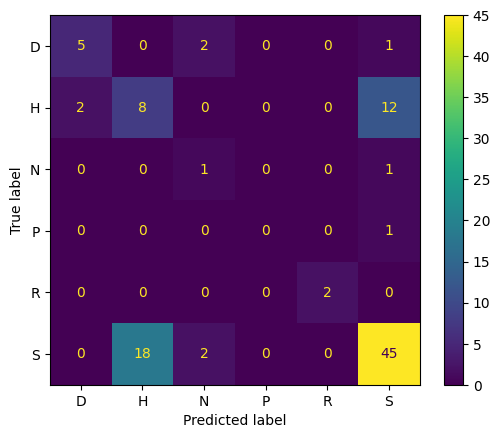

In [20]:
from sklearn import metrics

predicted_y = model.predict(X['test'])
print(metrics.classification_report(y['test'], predicted_y))

metrics.ConfusionMatrixDisplay.from_estimator(model, X['test'], y['test'])


ValueError: x, y, and format string must not be None

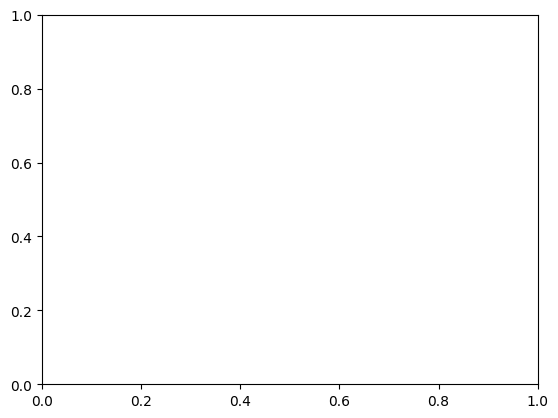

In [34]:
import matplotlib.pyplot as plt

def showAccuracy(model):
    plt.plot(model.validation_scores_)
    plt.title("Accuracy Curve")
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.show()

def showLosses(model):
    plt.plot(model.loss_curve_)
    plt.title("Loss Curve")
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()

showAccuracy(model)
showLosses(model)

In [30]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "solver": ["adam", "sgd"],
    "learning_rate": ["constant", "adaptive"],
    "hidden_layer_sizes": [(150,), (200,), (300,), (350,)],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring="accuracy",
    n_jobs=-1,
    cv=4,
    verbose=1,
    return_train_score=False,
)

grid_search.fit(X['train'], y['train'])
display(grid_search.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


{'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'solver': 'sgd'}

/home/yui/projects/_BCIT/4948/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yui/projects/_BCIT/4948/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yui/projects/_BCIT/4948/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

           D       0.71      0.62      0.67         8
           H       0.31      0.36      0.33        22
           N       0.17      0.50      0.25         2
           P       0.00      0.00      0.00         1
           R       0.67      1.00      0.80         2
           S       0.74      0.66      0.70        65

    accuracy                           0.59       100
   macro avg       0.43      0.53      0.46       100
weighted avg       0.62      0.59      0.60       100



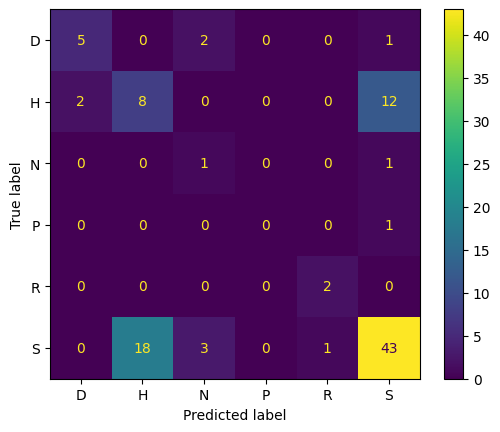

In [32]:
optimized_model = MLPClassifier(**grid_search.best_params_, max_iter=2000)
optimized_model.fit(X['train'], y['train'])
scores = perform_cv(model, 10)

predicted_y = model.predict(X['test'])
print(metrics.classification_report(y['test'], predicted_y))

metrics.ConfusionMatrixDisplay.from_estimator(model, X['test'], y['test'])